# Riiid! Answer Correctness Prediction - Intro
Team: EE258_F20_StudentPredictor

Author: Rendale Mark Taas

Last edited: 30-Dec-2020

This model was designed to use a complex network with an LSTM to extract time dependant trends. Since data is formatted as a time series, inputs are build on a per user basis. When training, a number of samples is pulled from each user. When testing, a database is saved and updated at each group/batch and takes into account new users. This database is in the variable 'test_user_dict'.

The hyperparameters are: the number of time steps in a series (variable timesteps), the number of samples per user (variable sampleperuser), the number of neurons per layer (variable lstm_neurons, ct_neurons, and dense_neurons), the learning rate (variable eta), and the number of training epochs (variable totalepoch).

In [1]:
# Script for competition "Riiid! Answer Correctness Prediction"
# Competition summary can be found here:
# https://www.kaggle.com/c/riiid-test-answer-prediction/overview

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import pandas as pd
import numpy as np
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


# Training Set Processing

In [2]:
#Load training data from csv file
#Data types are explicitly specified to minimize memory usage
subset_size = int(5E6)
train_df = pd.read_csv(
    'train.csv',
    low_memory=False,
    nrows=subset_size,
    dtype={
        'row_id': 'int64',
        'timestamp': 'int64',
        'user_id': 'int32',
        'content_id': 'int16',
        'content_type_id': 'int8',
        'task_container_id': 'int16',
        'user_answer': 'int8',
        'answered_correctly': 'int8',
        'prior_question_elapsed_time': 'float32', 
        'prior_question_had_explanation': 'boolean'
    }
)
print(train_df.dtypes)
print('From .csv loading train_df: rows, columns =', train_df.shape)

row_id                              int64
timestamp                           int64
user_id                             int32
content_id                          int16
content_type_id                      int8
task_container_id                   int16
user_answer                          int8
answered_correctly                   int8
prior_question_elapsed_time       float32
prior_question_had_explanation    boolean
dtype: object
From .csv loading train_df: rows, columns = (5000000, 10)


In [6]:
#Quick glimpse at the training data
train_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,25506.582031,0
1,1,56943,115,5716,0,2,2,1,37000.000000,0
2,2,118363,115,128,0,0,0,1,55000.000000,0
3,3,131167,115,7860,0,3,0,1,19000.000000,0
4,4,137965,115,7922,0,4,1,1,11000.000000,0
...,...,...,...,...,...,...,...,...,...,...
4999995,4999995,4151535711,106763796,3610,0,312,1,1,21000.000000,1
4999996,4999996,4151558505,106763796,8907,0,313,3,1,19000.000000,1
4999997,4999997,4151583786,106763796,4039,0,314,2,1,12000.000000,1
4999998,4999998,4231505166,106763796,996,0,316,0,1,13000.000000,1


In [7]:
#Remove unused columns
train_df.drop(['user_answer'], axis=1, inplace=True)
print('After dropping train_df: rows, columns =', train_df.shape)

After dropping train_df: rows, columns = (5000000, 9)


In [8]:
#Define data frame preprocesser (removes nans and converts bools)
mean_pqet = train_df['prior_question_elapsed_time'].mean()
def df_preprocess(in_df):
    in_df['prior_question_elapsed_time'].fillna(value=mean_pqet, inplace=True)
    in_df['prior_question_had_explanation'] = in_df[
        'prior_question_had_explanation'
    ].fillna(value=False).astype(bool).map({True:1, False:0})
    in_df.fillna(value=0, inplace=True)
    
df_preprocess(train_df)
print('After preprocessing train_df: rows, columns', train_df.shape)

After preprocessing train_df: rows, columns (5000000, 9)


In [9]:
train_df

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,1,25506.582031,0
1,1,56943,115,5716,0,2,1,37000.000000,0
2,2,118363,115,128,0,0,1,55000.000000,0
3,3,131167,115,7860,0,3,1,19000.000000,0
4,4,137965,115,7922,0,4,1,11000.000000,0
...,...,...,...,...,...,...,...,...,...
4999995,4999995,4151535711,106763796,3610,0,312,1,21000.000000,1
4999996,4999996,4151558505,106763796,8907,0,313,1,19000.000000,1
4999997,4999997,4151583786,106763796,4039,0,314,1,12000.000000,1
4999998,4999998,4231505166,106763796,996,0,316,1,13000.000000,1


In [10]:
#Group by user and how many rows they have in the dataset
train_by_user_id = train_df.groupby(by='user_id')
user_list = list(train_by_user_id.groups.keys())
print('There are', len(user_list), 'users')
print('Average rows per user:', train_by_user_id.count().mean()[0])
print('Min rows of one user:', train_by_user_id.count().min()[0])
print('Max rows of one user:', train_by_user_id.count().max()[0])

#Delete all large variables not used past this point to conserve memory
del train_by_user_id

There are 19532 users
Average rows per user: 255.99016997747287
Min rows of one user: 1
Max rows of one user: 15871


In [11]:
#Group by question, and create dictionary
#Dictionary has the question's mean, standard deviation, and skew
train_by_content_id = train_df.loc[train_df.content_type_id==0].groupby(by='content_id')
content_id_dict = train_by_content_id.agg({'answered_correctly': [np.mean, np.std, 'skew']}).copy()
content_id_dict.columns = ['content_mean', 'content_std', 'content_skew']
content_id_dict.fillna(value=0, inplace=True)

#Delete all large variables not used past this point to conserve memory
del train_by_content_id

In [12]:
#Group by container id, and create dictionary
#Dictionary has the container's mean, standard deviation, and skew
train_by_container = train_df.loc[train_df.content_type_id==0].groupby(by='task_container_id')
container_dict = train_by_container.agg({'answered_correctly': [np.mean, np.std, 'skew']}).copy()
container_dict.columns = ['container_mean', 'container_std', 'container_skew']
container_dict.fillna(value=0, inplace=True)

#Delete all large variables not used past this point to conserve memory
del train_by_container

In [32]:
#From the questions metadata, create dictionary of part and tags
questions_df = pd.read_csv('questions.csv')
questions_df.drop(['bundle_id', 'correct_answer'], axis=1, inplace=True)
#Tagless questions are given the tag '-1'
questions_df.fillna(value=-1, inplace=True)
questions_df.rename(columns={'question_id':'content_id'}, inplace=True)
total_q = len(questions_df)
tag_list = []
first_tag_list = []
tag_counts = {}
for thisindex, thisstr in enumerate(questions_df.tags):
    temp_list = str(thisstr).split(' ')
    temp_list = [int(i) for i in temp_list]
    tag_list.append(temp_list)
    first_tag_list.append(temp_list[0])
    for thistag in temp_list:
        if (not(thistag in tag_counts)):
            tag_counts[thistag] = 0
        tag_counts[thistag] = tag_counts[thistag] + 1

questions_df['tags'] = tag_list
questions_df['first_tag'] = first_tag_list

tag_dict = {}
for thistag in tag_counts:
    temp_df = questions_df.loc[
        [(thistag in questions_df.tags[i]) for i in range(total_q)]
    ]
    temp_list = temp_df.content_id.tolist()
    tag_dict[thistag] = temp_list



In [36]:
total_q

13523

In [34]:
#Delete all large variables not used past this part to conserve memory
del tag_list, first_tag_list

In [39]:
tag_counts

{51: 71,
 131: 650,
 162: 914,
 38: 2256,
 36: 35,
 81: 1969,
 101: 52,
 92: 2269,
 149: 53,
 29: 1707,
 5: 85,
 10: 293,
 94: 27,
 61: 49,
 110: 49,
 13: 24,
 164: 56,
 99: 36,
 93: 58,
 70: 46,
 9: 124,
 104: 72,
 40: 27,
 130: 37,
 187: 45,
 102: 789,
 111: 38,
 178: 39,
 143: 712,
 30: 105,
 90: 214,
 100: 203,
 176: 105,
 140: 112,
 6: 8,
 2: 144,
 107: 120,
 114: 121,
 138: 104,
 41: 100,
 141: 65,
 137: 115,
 142: 17,
 119: 93,
 148: 110,
 69: 69,
 62: 194,
 155: 209,
 163: 132,
 129: 50,
 105: 42,
 71: 61,
 88: 112,
 32: 119,
 20: 100,
 17: 38,
 56: 39,
 74: 476,
 136: 1033,
 82: 527,
 106: 457,
 157: 206,
 113: 156,
 161: 146,
 186: 3,
 12: 339,
 103: 192,
 67: 327,
 171: 81,
 144: 162,
 169: 72,
 126: 57,
 158: 26,
 83: 18,
 150: 30,
 183: 15,
 120: 18,
 8: 751,
 4: 50,
 166: 60,
 85: 24,
 156: 43,
 53: 544,
 73: 630,
 66: 41,
 108: 20,
 173: 226,
 72: 72,
 95: 17,
 7: 78,
 15: 12,
 132: 13,
 180: 29,
 75: 23,
 49: 16,
 55: 312,
 109: 210,
 60: 109,
 125: 57,
 133: 62,
 152: 

In [37]:
questions_df

,content_id,part,tags,first_tag
0,0,1,"[51, 131, 162, 38]",51
1,1,1,"[131, 36, 81]",131
2,2,1,"[131, 101, 162, 92]",131
3,3,1,"[131, 149, 162, 29]",131
4,4,1,"[131, 5, 162, 38]",131
...,...,...,...,...
13518,13518,5,[14],14
13519,13519,5,[8],8
13520,13520,5,[73],73
13521,13521,5,[125],125


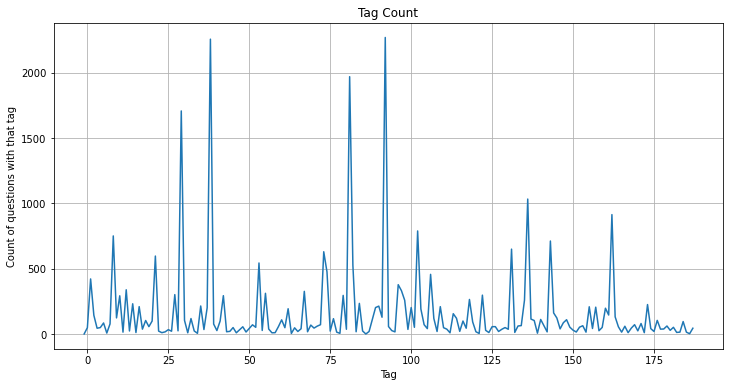

In [24]:
#See the frequency of each tag
plt.figure(figsize=(12,6))
plt.plot(*zip(*sorted(tag_counts.items())))
plt.xlabel('Tag')
plt.ylabel('Count of questions with that tag')
plt.title('Tag Count')
plt.grid(True)

In [40]:
#Get statistics per tag
stats_tag_dict = {}
for thistag in tag_dict:
    temp_df = train_df.loc[train_df.content_type_id==0]
    temp_df = temp_df.loc[temp_df['content_id'].isin(tag_dict[thistag])]
    tag_weight = len(temp_df)
    temp_df = temp_df.agg({'answered_correctly': [np.mean, np.std, 'skew']})
    if(not(thistag in stats_tag_dict)):
        stats_tag_dict[thistag] = {}
    stats_tag_dict[thistag]['tag_mean'] = temp_df.loc['mean'][0]
    stats_tag_dict[thistag]['tag_std'] = temp_df.loc['std'][0]
    stats_tag_dict[thistag]['tag_skew'] = temp_df.loc['skew'][0]
    stats_tag_dict[thistag]['weight'] = tag_weight

#For each question find the weighted average statistic
comb_tag_stat_list = []
for thislist in questions_df.tags:
    mean_list = []
    std_list = []
    skew_list = []
    weight_list = []
    for thistag in thislist:
        mean_list.append(stats_tag_dict[thistag]['tag_mean'])
        std_list.append(stats_tag_dict[thistag]['tag_std'])
        skew_list.append(stats_tag_dict[thistag]['tag_skew'])
        weight_list.append(stats_tag_dict[thistag]['weight'])
    if(weight_list[0]==0):
        comb_tag_stat_list.append(np.array([0.5, 0, 0]))
    else:
        temp_array = np.array([mean_list, std_list, skew_list])
        comb_tag_stat_list.append(np.average(temp_array, axis=1, weights=weight_list))

questions_df = questions_df.merge(
    pd.DataFrame(comb_tag_stat_list),
    left_index=True,
    right_index=True
)
questions_df.rename(
    columns={
        0: 'tag_mean',
        1: 'tag_std',
        2: 'tag_skew'
    },
    inplace=True
)
questions_df.drop(['tags'], axis=1, inplace=True)

#Delete all large variables not used past this part to conserve memory
del stats_tag_dict, tag_dict, tag_counts

In [41]:
questions_df

,content_id,part,first_tag,tag_mean,tag_std,tag_skew
0,0,1,51,0.730609,0.442497,-1.048731
1,1,1,131,0.727339,0.443104,-1.038128
2,2,1,131,0.714180,0.449862,-0.961963
3,3,1,131,0.728176,0.443019,-1.040761
4,4,1,131,0.730331,0.442702,-1.046631
...,...,...,...,...,...,...
13518,13518,5,14,0.695840,0.460057,-0.851419
13519,13519,5,8,0.620549,0.485253,-0.496859
13520,13520,5,73,0.588394,0.492126,-0.359239
13521,13521,5,125,0.634136,0.481680,-0.556990


In [44]:
#From the lectures metadata, create dictionary of part and tags
lectures_df = pd.read_csv('lectures.csv')
lectures_df.fillna(value=0)
lectures_df.drop(['type_of'], axis=1, inplace=True)
lectures_df.rename(columns={'lecture_id': 'content_id', 'tag': 'first_tag'}, inplace=True)
lectures_df['tag_mean'] = -1
lectures_df['tag_std'] = 0
lectures_df['tag_skew'] = 0

In [45]:
#Define function to merge all dictionaries onto dataset
def merge_all_dict(in_df):
    temp_df = in_df.merge(content_id_dict, how='left', on='content_id')
    temp_df = temp_df.merge(container_dict, how='left', on='task_container_id')
    temp_df.loc[
        temp_df.content_type_id==1,
        ['container_mean', 'content_mean']
    ] = -1
    temp_df.loc[
        temp_df.content_type_id==1,
        ['container_std', 'container_skew', 'content_std', 'content_skew']
    ] = 0
    
    leconly_df = temp_df.merge(lectures_df, how='left', on='content_id')
    queonly_df = temp_df.merge(questions_df, how='left', on='content_id')[
        ['first_tag', 'part', 'tag_mean', 'tag_std', 'tag_skew']
    ]
    temp_df = leconly_df.combine_first(queonly_df)
    
    return temp_df.fillna(value=0).reset_index(drop=True)
    
train_df = merge_all_dict(train_df)
print('After merge, (rows, columns) =', train_df.shape)

After merge, (rows, columns) = (5000000, 20)


In [46]:
#Quick glimpse at the data after processing
train_df.iloc[80:100]

,answered_correctly,container_mean,container_skew,container_std,content_id,content_mean,content_skew,content_std,content_type_id,first_tag,part,prior_question_elapsed_time,prior_question_had_explanation,row_id,tag_mean,tag_skew,tag_std,task_container_id,timestamp,user_id
80,0,0.482737,0.069095,0.499709,404,0.667606,-0.713101,0.471404,0,138.0,2.0,20000.000000,0,80,0.708814,-0.919706,0.454236,4,91945,2746
81,1,0.411516,0.359628,0.492116,382,0.806883,-1.559324,0.395122,0,90.0,2.0,16000.000000,0,81,0.691978,-0.831903,0.461632,5,111621,2746
82,1,0.320073,0.771418,0.466511,405,0.591433,-0.372190,0.491650,0,17.0,2.0,16000.000000,0,82,0.699949,-0.873977,0.458042,6,134341,2746
83,1,0.503171,-0.012684,0.499997,873,0.650838,-0.634165,0.477038,0,62.0,2.0,19000.000000,0,83,0.692920,-0.837704,0.461063,7,234605,2746
84,1,0.507044,-0.028182,0.499963,531,0.748479,-1.148859,0.434328,0,143.0,2.0,18000.000000,1,84,0.709863,-0.925159,0.453777,8,283894,2746
85,0,0.436549,0.255891,0.495970,775,0.634146,-0.557763,0.481886,0,129.0,2.0,18000.000000,1,85,0.711157,-0.932493,0.453117,9,328640,2746
86,1,0.560913,-0.245498,0.496288,294,0.871846,-2.225391,0.334287,0,155.0,2.0,20000.000000,1,86,0.710775,-0.929989,0.453365,10,357471,2746
87,1,0.463057,0.148187,0.498646,714,0.751244,-1.165280,0.432651,0,62.0,2.0,13000.000000,1,87,0.710632,-0.929635,0.453364,11,384415,2746
88,0,0.482716,0.069183,0.499714,297,0.882662,-2.384361,0.322105,0,129.0,2.0,13000.000000,1,88,0.699236,-0.870117,0.458386,12,428637,2746
89,-1,-1.000000,0.000000,0.000000,6808,-1.000000,0.000000,0.000000,1,21858.0,2.0,25506.582031,0,89,-1.000000,0.000000,0.000000,14,653762,2746


In [47]:
#Define the labels of the input vector
#Columns that need to be scaled are first
scaled_labels = [
    'timestamp',
    'prior_question_elapsed_time',
    'content_id',
    'part',
    'first_tag',
    'task_container_id'
]
stat_labels = [
    'content_mean',
    'content_std',
    'content_skew',
    'container_mean',
    'container_std',
    'container_skew',
    'tag_mean',
    'tag_std',
    'tag_skew'
]
other_labels = [
    'prior_question_had_explanation',
    'content_type_id',
    'answered_correctly'
]
all_labels = scaled_labels + stat_labels + other_labels
sindex = len(scaled_labels)

#Define input shapes
timesteps = 100
features = len(all_labels)

In [48]:
#Create scaler for first set of labels
print('Creating scaler for preprocessing:')
scaler = StandardScaler()
scaler.fit(train_df[scaled_labels].to_numpy())

Creating scaler for preprocessing:


StandardScaler()

In [49]:
#Define function that will get the relevant features for time series
#Will scale all features that need it
def build_ts_array(in_df):
    out_np = in_df[all_labels].to_numpy()
    out_np[:, 0:sindex] = scaler.transform(out_np[:, 0:sindex])
    return out_np

#Define function that will get features for current time sample
def build_ct_array(in_df):
    out_np = in_df[all_labels[:-2]].to_numpy()
    out_np[:, 0:sindex] = scaler.transform(out_np[:, 0:sindex])
    return out_np

In [50]:
#Define function that returns samples of a given user
#Data will be front padded if the number of rows is less than timesteps
def user_sample_array(in_df, inuser, numsamples):
    temp_df = in_df.loc[in_df.user_id==inuser].reset_index(drop=True)
    ts_list = []
    ct_list = []
    y_list = []
    #.iloc includes the first argument, but excludes the second, thus ts is properly shifted
    if(len(temp_df)>1):
        for i in range(len(temp_df)-1, 0, -math.ceil(len(temp_df) / numsamples)):
            if(temp_df.iloc[i].content_type_id==1):
                continue
            next_ts = build_ts_array(temp_df.iloc[max(0, i-timesteps):i])
            next_ct = build_ct_array(temp_df.iloc[i:i+1])
            next_y = temp_df['answered_correctly'].iloc[i]
            if (len(next_ts) < timesteps):
                next_ts = np.vstack((
                    np.zeros((timesteps - len(next_ts), features)),
                    next_ts
                ))
            ts_list.append(next_ts)
            ct_list.append(next_ct)
            y_list.append(next_y)
    else:
        if(temp_df.content_type_id[0]==0):
            next_ts = np.zeros((timesteps, features))
            next_ct = build_ct_array(temp_df)
            next_y = temp_df['answered_correctly'].iloc[0]
            ts_list.append(next_ts)
            ct_list.append(next_ct)
            y_list.append(next_y)
    return ts_list, ct_list, y_list

In [52]:
#Create the training set
xts_train_list = []
xct_train_list = []
y_train_list = []

#Building the set, each sample is the time series of one user
time_start = time.time()
print('Start creating training set at', time.ctime())
sampleperuser = 3
for thisuser in user_list:
    ts_list, ct_list, y_list = user_sample_array(train_df, thisuser, sampleperuser)
    for tssample, ctsample, ysample in zip(ts_list, ct_list, y_list):
        xts_train_list.append(tssample)
        xct_train_list.append(ctsample)
        y_train_list.append(ysample)

xts_train = np.array(xts_train_list)
xct_train = np.array(xct_train_list)
y_train = np.array(y_train_list)
xct_train = np.reshape(xct_train, (len(y_train), features-2))

time_finish = time.time()
print('Finished at', time.ctime())
print('Time elapsed:', int(time_finish - time_start), 'sec')
print('Shape of xts_train:', xts_train.shape)
print('Shape of xct_train:', xct_train.shape)
print('Shape of y_train:', y_train.shape)

#Delete all large variables not used past this point to conserve memory
del xts_train_list, xct_train_list, y_train_list

Start creating training set at Mon Feb 14 17:11:22 2022
Finished at Mon Feb 14 17:13:58 2022
Time elapsed: 156 sec
Shape of xts_train: (57712, 100, 18)
Shape of xct_train: (57712, 16)
Shape of y_train: (57712,)


In [53]:
#Show example time sample array for training
print('Time series example:')
for i, thislabel in enumerate(all_labels):
    print('{:>32}'.format(thislabel), end=': ')
    for val in xts_train[0, -5:, i]:
        print('{:>8.4f}'.format(val), end=' ')
    print('')
print('\nCurrent time example:')
for i, thislabel in enumerate(all_labels[:-2]):
    print('{:>32}'.format(thislabel), end=': ')
    print('{:>8.4f}'.format(xct_train[0, i]), end=' ')
    print('')
print('\nActual result:', y_train[0])

Time series example:
                       timestamp:  -0.6076  -0.6076  -0.6076  -0.6076  -0.6076 
     prior_question_elapsed_time:  -0.4304  -0.4304  -0.4304  -0.5645  -0.5645 
                      content_id:  -0.8131  -0.8134  -0.8136  -0.4780  -0.4775 
                            part:  -0.6424  -0.6424  -0.6424  -0.0499  -0.0499 
                       first_tag:  -0.1416  -0.1351  -0.1416  -0.1607  -0.1416 
               task_container_id:  -0.6412  -0.6412  -0.6412  -0.6404  -0.6404 
                    content_mean:   0.6409   0.6356   0.1686   0.2880   0.3016 
                     content_std:   0.4798   0.4813   0.3744   0.4528   0.4590 
                    content_skew:  -0.5877  -0.5637   1.7707   0.9366   0.8649 
                  container_mean:   0.6468   0.6468   0.6468   0.6406   0.6406 
                   container_std:   0.4780   0.4780   0.4780   0.4798   0.4798 
                  container_skew:  -0.6142  -0.6142  -0.6142  -0.5862  -0.5862 
                   

In [54]:
#Shuffle and split for validation
xts_train, xts_val, xct_train, xct_val, y_train, y_val = train_test_split(
    xts_train,
    xct_train,
    y_train,
    test_size = 1/10,
    random_state = 17,
    shuffle = True
)
print('After split:')
print('# of training data:', xts_train.shape[0])
print('# of validation data:', xts_val.shape[0])

After split:
# of training data: 51940
# of validation data: 5772


In [55]:
#Delete all large variables not used past this point to conserve memory
del train_df

# Model Creation and Training

In [56]:
#Define hyperparameters
eta = 5E-3
totalepoch = 50

lstm_neurons = 50
ct_neurons = 10
dense_neurons = 10

lstm_r_reg = 1E-4
lstm_i_reg = 5E-4
ct_reg = 5E-4
comb_reg = 1E-5

In [57]:
#Build model
from tensorflow.keras.optimizers import Adam

#Create inputs
ts_input = keras.Input(shape=(timesteps, features), name='ts_input')
ct_input = keras.Input(shape=(features-2), name='ct_input')

#Time series path
ts_mask = layers.Masking(
    mask_value=0.,
    name='ts_mask'
)(ts_input)
ts_state = layers.LSTM(
    lstm_neurons,
    recurrent_regularizer=regularizers.l1(lstm_r_reg),
    kernel_regularizer=regularizers.l1(lstm_i_reg),
    name='ts_lstm'
)(ts_mask)

#Current time path
ct_state = layers.Dense(
    ct_neurons,
    activation='relu',
    kernel_regularizer=regularizers.l1(ct_reg),
    name='ct_dense'
)(ct_input)

#Combined path
statemerge = layers.Concatenate(
    name='comb_concat'
)([ts_state, ct_state])
comb_dense = layers.Dense(
    dense_neurons,
    activation='relu',
    kernel_regularizer=regularizers.l1(comb_reg),
    name='comb_dense'
)(statemerge)
ans_pred = layers.Dense(
    1,
    activation='sigmoid',
    name='ans_pred'
)(comb_dense)

#Model compile
model = keras.Model(
    inputs=[ts_input, ct_input],
    outputs=[ans_pred],
    name='advancedmodel'
)

opt_adam = Adam(learning_rate=eta)
model.compile(
    optimizer=opt_adam,
    loss='mse',
    metrics=['AUC']
)
model.summary()

Model: "advancedmodel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ts_input (InputLayer)           [(None, 100, 18)]    0                                            
__________________________________________________________________________________________________
ts_mask (Masking)               (None, 100, 18)      0           ts_input[0][0]                   
__________________________________________________________________________________________________
ct_input (InputLayer)           [(None, 16)]         0                                            
__________________________________________________________________________________________________
ts_lstm (LSTM)                  (None, 50)           13800       ts_mask[0][0]                    
______________________________________________________________________________________

In [25]:
#Fit model to training set
time_start = time.time()
print('Training start at', time.ctime())
history = model.fit(
    (xts_train, xct_train),
    y_train,
    batch_size=1024,
    epochs=totalepoch,
    validation_data=((xts_val, xct_val), y_val),
    verbose=0
)
time_finish = time.time()
print('Training finished at', time.ctime())
print('Time elapsed:', int(time_finish - time_start), 'sec')

Training start at Thu Dec 31 01:43:56 2020
Training finished at Thu Dec 31 02:05:44 2020
Time elapsed: 1307 sec


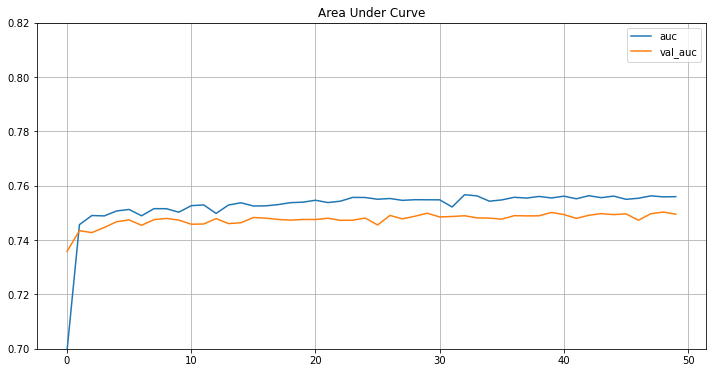

In [26]:
pd.DataFrame(history.history)[['auc','val_auc']].plot(figsize=(12,6))
plt.grid(True)
plt.gca().set_ylim(0.7, 0.82)
plt.title('Area Under Curve')
plt.show()

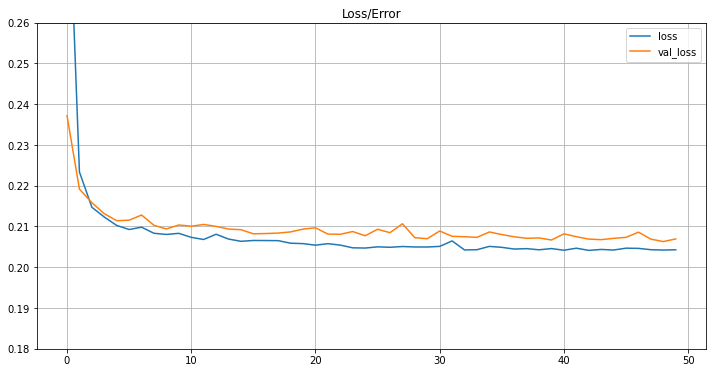

In [27]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(12,6))
plt.grid(True)
plt.gca().set_ylim(0.18, 0.26)
plt.title('Loss/Error')
plt.show()

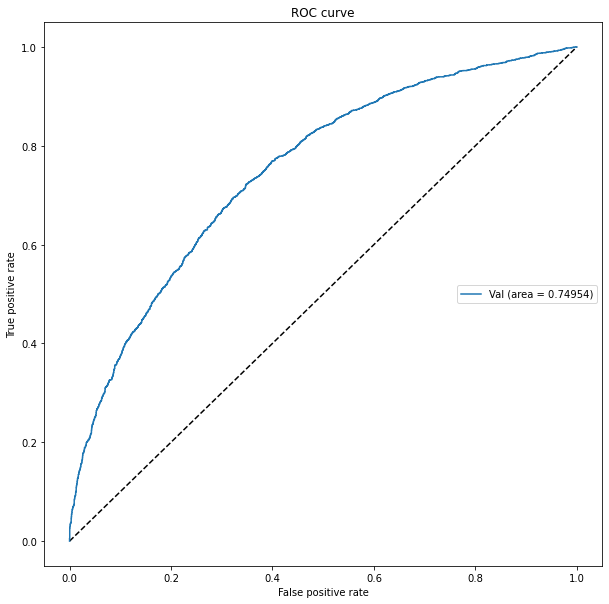

In [28]:
#Apply model on the validation set, and show ROC curve
y_val_pred = model.predict((xts_val, xct_val)).ravel()
fpr_val, tpr_val, thresh_val = roc_curve(y_val.astype(np.uint8), y_val_pred)
auc_val = auc(fpr_val, tpr_val)
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_val, tpr_val, label='Val (area = {:.5f})'.format(auc_val))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='center right')
plt.show()

In [29]:
#Show example prediction
print('{:>10}'.format('Expected'), '{:>11}'.format('Prediction'))
for i in range(10):
    print('{:>10.7f}'.format(y_val[i]), '{:>11.7f}'.format(y_val_pred[i]))

  Expected  Prediction
 1.0000000   0.5196126
 1.0000000   0.3133956
 1.0000000   0.9269359
 1.0000000   0.3323289
 0.0000000   0.3271252
 1.0000000   0.4986564
 0.0000000   0.5094691
 1.0000000   0.4110934
 1.0000000   0.5822345
 1.0000000   0.8185859


In [30]:
weights = model.trainable_weights
lstm_input_w = [0]*features
for i in range(features):
    temp_array = weights[0][i,::4]
    temp_array = [abs(j) for j in temp_array]
    lstm_input_w[i] = np.mean(temp_array)
lstm_input_w_scaled = 1000*(lstm_input_w/max(lstm_input_w))

print('Time series/LSTM feature relevance')
print('{:>30}'.format('FEATURE'), '{:>9}'.format('WEIGHT'), '{:>8}'.format('RELATIVE'))
for i, val in enumerate(lstm_input_w):
    print(
        '{:>30}'.format(all_labels[i]),
        '{:>9.6f}'.format(val),
        '{:>8}'.format(lstm_input_w_scaled[i].astype(int))
    )
    
dense_input_w = [0]*(features-2)
for i in range(features-2):
    temp_array = weights[3][i]
    temp_array = [abs(j) for j in temp_array]
    dense_input_w[i] = np.mean(temp_array)
dense_input_w_scaled = 1000*(dense_input_w/max(dense_input_w))

print('\nCurrent time feature relevance')
print('{:>30}'.format('FEATURE'), '{:>9}'.format('WEIGHT'), '{:>8}'.format('RELATIVE'))
for i, val in enumerate(dense_input_w):
    print(
        '{:>30}'.format(all_labels[i]),
        '{:>9.6f}'.format(val),
        '{:>8}'.format(dense_input_w_scaled[i].astype(int))
    )

Time series/LSTM feature relevance
                       FEATURE    WEIGHT RELATIVE
                     timestamp  0.000965      799
   prior_question_elapsed_time  0.001155      957
                    content_id  0.001200      994
                          part  0.000636      526
                     first_tag  0.000717      593
             task_container_id  0.000773      640
                  content_mean  0.000892      738
                   content_std  0.000714      591
                  content_skew  0.001207     1000
                container_mean  0.000790      654
                 container_std  0.000656      543
                container_skew  0.000790      654
                      tag_mean  0.000813      673
                       tag_std  0.000781      647
                      tag_skew  0.000901      746
prior_question_had_explanation  0.000843      698
               content_type_id  0.000525      434
            answered_correctly  0.000829      686

Current time f

In [31]:
#Delete all large variables not used past this point to conserve memory
del xts_train, xct_train, y_train, xts_val, xct_val, y_val

# Model Predictions

In [32]:
# The environment can only be created once, per Riiid rules
# If you need to rerun the script, first kill the session/kernel
env = riiideducation.make_env()

#Load test data. Each batch of tests is along the principle axis, and must be followed in a strict order (to emulate the passage of time).
#An iteration of test must call 'env.predict()' else there will be an error
iter_test = env.iter_test()

#Apply model, and place results in prediction_df with the 'env.predict()' function, such as below
#>>env.predict(prediction_df)
#After the iter_test tuple is exhausted, the environment will output the final prediction in submission.csv
test_user_dict = {}
old_user_list = []
old_row_list = []
old_test_df = pd.DataFrame({'empty': [0]})
for (test_df, prediction_df) in iter_test:
    
    #Preprocessing
    test_df = test_df.reset_index(drop=True)
    #Get answers from previous group
    pgac_list = eval(str(test_df['prior_group_answers_correct'].iloc[0]))
    #Drop columns
    test_df.drop(['prior_group_responses', 'prior_group_answers_correct'], axis=1, inplace=True)
    df_preprocess(test_df)
    #Get user list and row list for this group
    new_user_list = test_df.user_id.tolist()
    new_row_list = test_df.row_id.tolist()
    #Merge dictionaries
    test_df = merge_all_dict(test_df)
    #Create answer column
    test_df['answered_correctly'] = [0.5]*len(test_df)
    test_df.fillna(value=0, inplace=True)
    
    #Update answered_correctly in previous group, then insert to dictionary
    if(pgac_list):
        pgac_dict = pd.DataFrame.from_dict({'row_id': old_row_list, 'answered_correctly': pgac_list})
        old_test_df = old_test_df.merge(pgac_dict, how='left', on='row_id')
        for thisindex, (thisrow, thisuser) in enumerate(zip(old_row_list, old_user_list)):
            if(not(thisuser in test_user_dict)):
                test_user_dict[thisuser] = {'rows': []}
            test_user_dict[thisuser][thisrow] = old_test_df.iloc[thisindex].tolist()
            test_user_dict[thisuser]['rows'].append(thisrow)
            if(len(test_user_dict[thisuser]['rows']) > timesteps):
                row_remove = test_user_dict[thisuser]['rows'].pop(0)
                test_user_dict[thisuser].pop(row_remove)    
    
    #Predict for each user in group
    xts_test_list = []
    xct_test_list  =[]
    prediction_rows = []
    for thisrow, thisuser in zip(new_row_list, new_user_list):
        temp_df = test_df.loc[test_df.row_id==thisrow]
        if(temp_df.content_type_id.iloc[0]==0):
            if(thisuser in test_user_dict):
                temp_dict = dict(test_user_dict[thisuser])
                temp_dict.pop('rows')
                database_df = pd.DataFrame.from_dict(temp_dict, orient='index', columns=test_df.columns)
                user_df = pd.concat([database_df, temp_df])
            else:
                user_df = temp_df
            next_ts, next_ct, next_y = user_sample_array(user_df, thisuser, 1)
            xts_test_list.append(next_ts[0])
            xct_test_list.append(next_ct[0])
            prediction_rows.append(thisrow)
        
    xts_test = np.array(xts_test_list)
    xct_test = np.array(xct_test_list)
    xct_test = np.reshape(xct_test, (xts_test.shape[0], features-2))
    pred_list = model.predict((xts_test, xct_test)).ravel()
    update_df = pd.DataFrame({'row_id': prediction_rows, 'prediction': pred_list})
    update_df.fillna(0.5, inplace=True)

    #Save new -> old
    old_test_df = test_df.drop(['answered_correctly'], axis=1)
    old_user_list = list(new_user_list)
    old_row_list = list(new_row_list)
    
    #Call env.predict()
    prediction_df = prediction_df.merge(update_df, how='left', on='row_id')
    prediction_df.drop(['answered_correctly'], axis=1, inplace=True)
    prediction_df.rename(columns={'prediction': 'answered_correctly'}, inplace=True)
    prediction_df = prediction_df.astype({'answered_correctly': 'float64'})
    prediction_df.fillna(0.5, inplace=True)
    env.predict(prediction_df)